# Implementation of the LDA algorithm using Gensim

In [1]:
import re
import nltk
import spacy
import gensim
import logging
import pyLDAvis
import warnings
import numpy as np
import pandas as pd
import pyLDAvis.gensim 
import gensim.corpora as corpora
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
from nltk.corpus import stopwords

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
df = pd.read_excel('posts_sample.xlsx')
df = df[df['main_post'] == 1]

In [3]:
# 'Body' contains the posts from the forum, on which the LDA algorithm will be applied to. 

df.head()

,superparent,id,main_post,datecreated,Title,Body
0,0,0,1,2017-06-15 16:18:02,Advice on symptoms please,Hello I wonder if anyone has any advice. I hav...
26,1,1,1,2017-06-17 18:49:24,Alcapa Syndrome,"Hi, I'm new here. Does anyone out there have ..."
32,2,2,1,2017-06-18 19:47:14,Post op confusion,"Hi, my dad had a double by pass op 4 days ago,..."
40,3,3,1,2017-06-19 15:43:30,Post heart attack blues,"Hi. I'm X. At the age of X, just having retire..."
55,4,4,1,2017-06-19 15:44:50,hello,"hi, i' m X, I had a heart attack 4 weeks ago a..."


In [4]:
# set stop words

nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dumitrescucristian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Convert data to list

data = df.Body.tolist()

pprint(data[:1])

['Hello I wonder if anyone has any advice. I have had a very stressful few '
 'months in my life. Last week I had breathing problems a shortness of breath '
 'with no pain. I went to urgent care who listened to my lungs and heart and '
 'said it was an anxiety attack. I went to my GP next day who said it was an '
 'anxiety attack to.\n'
 "Since then I have managed to ease the attacks but I've been experiencing "
 'some tingling of and on in left arm. Again a dull pain in left of chest just '
 'above the left breast. Again of and on . Does this sound like a heart attack '
 'is building ? Or could it. E the aftermath of anxiety . \n'
 'I am worried to go back to gp incase I am getting on there nerves.\n'
 'Also would listening in with stethoscope show if there was a problem with '
 'the heart ? \n'
 'Thanks in advance ']


In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['hello', 'wonder', 'if', 'anyone', 'has', 'any', 'advice', 'have', 'had', 'very', 'stressful', 'few', 'months', 'in', 'my', 'life', 'last', 'week', 'had', 'breathing', 'problems', 'shortness', 'of', 'breath', 'with', 'no', 'pain', 'went', 'to', 'urgent', 'care', 'who', 'listened', 'to', 'my', 'lungs', 'and', 'heart', 'and', 'said', 'it', 'was', 'an', 'anxiety', 'attack', 'went', 'to', 'my', 'gp', 'next', 'day', 'who', 'said', 'it', 'was', 'an', 'anxiety', 'attack', 'to', 'since', 'then', 'have', 'managed', 'to', 'ease', 'the', 'attacks', 'but', 've', 'been', 'experiencing', 'some', 'tingling', 'of', 'and', 'on', 'in', 'left', 'arm', 'again', 'dull', 'pain', 'in', 'left', 'of', 'chest', 'just', 'above', 'the', 'left', 'breast', 'again', 'of', 'and', 'on', 'does', 'this', 'sound', 'like', 'heart', 'attack', 'is', 'building', 'or', 'could', 'it', 'the', 'aftermath', 'of', 'anxiety', 'am', 'worried', 'to', 'go', 'back', 'to', 'gp', 'incase', 'am', 'getting', 'on', 'there', 'nerves', 'als

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
 
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# See example
print(bigram_mod[data_words[0]])

['hello', 'wonder_if', 'anyone', 'has', 'any_advice', 'have', 'had', 'very', 'stressful', 'few_months', 'in', 'my', 'life', 'last_week', 'had', 'breathing', 'problems', 'shortness_of', 'breath', 'with', 'no', 'pain', 'went', 'to', 'urgent', 'care', 'who', 'listened', 'to', 'my', 'lungs', 'and', 'heart', 'and', 'said', 'it', 'was', 'an', 'anxiety', 'attack', 'went', 'to', 'my_gp', 'next_day', 'who', 'said', 'it', 'was', 'an', 'anxiety', 'attack', 'to', 'since_then', 'have', 'managed', 'to', 'ease', 'the', 'attacks', 'but', 've_been', 'experiencing', 'some', 'tingling', 'of', 'and', 'on', 'in', 'left_arm', 'again', 'dull', 'pain', 'in', 'left', 'of', 'chest', 'just', 'above', 'the', 'left', 'breast', 'again', 'of', 'and', 'on', 'does', 'this', 'sound', 'like', 'heart_attack', 'is', 'building', 'or', 'could', 'it', 'the', 'aftermath', 'of', 'anxiety', 'am', 'worried', 'to', 'go_back', 'to', 'gp', 'incase', 'am', 'getting', 'on', 'there', 'nerves', 'also', 'would', 'listening', 'in', 'with

In [8]:
# Define functions for stopwords, bigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en', disable=['parser', 'ner'])

# lemmatization 
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Example of processed data
print(data_lemmatized[:1])

[['wonder', 'advice', 'stressful', 'month', 'life', 'last_week', 'breathing', 'problem', 'shortness', 'breath', 'pain', 'go', 'urgent', 'care', 'listen', 'lung', 'heart', 'say', 'anxiety', 'attack', 'go', 'next_day', 'say', 'anxiety', 'attack', 'manage', 'ease', 'attack', 'experience', 'tingle', 'dull', 'pain', 'leave', 'chest', 'left', 'breast', 'sound', 'building', 'could', 'aftermath', 'anxiety', 'worry', 'incase', 'get', 'nerve', 'also', 'would', 'listen', 'stethoscope', 'show', 'problem', 'heart', 'thank', 'advance']]


In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3), (5, 3), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 2), (32, 2), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1)]]


In [11]:
id2word[0]

'advance'

In [12]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('advance', 1),
  ('advice', 1),
  ('aftermath', 1),
  ('also', 1),
  ('anxiety', 3),
  ('attack', 3),
  ('breast', 1),
  ('breath', 1),
  ('breathing', 1),
  ('building', 1),
  ('care', 1),
  ('chest', 1),
  ('could', 1),
  ('dull', 1),
  ('ease', 1),
  ('experience', 1),
  ('get', 1),
  ('go', 2),
  ('heart', 2),
  ('incase', 1),
  ('last_week', 1),
  ('leave', 1),
  ('left', 1),
  ('life', 1),
  ('listen', 2),
  ('lung', 1),
  ('manage', 1),
  ('month', 1),
  ('nerve', 1),
  ('next_day', 1),
  ('pain', 2),
  ('problem', 2),
  ('say', 2),
  ('shortness', 1),
  ('show', 1),
  ('sound', 1),
  ('stethoscope', 1),
  ('stressful', 1),
  ('thank', 1),
  ('tingle', 1),
  ('urgent', 1),
  ('wonder', 1),
  ('worry', 1),
  ('would', 1)]]

#### A limitation of the LDA algorithm is that the number of topics have to be specified.

* In this problem, I do not know what the number of topics is, as this is something that needs to be found.
* To overcome this problem, I run the algorithm several times with different number of topics, and I have plotted the perplexity and coherence scores for each case.
* It can be seen from the two plots underneath that the best number of topics is 11, as it has the highest coherence and a small perplexity. 

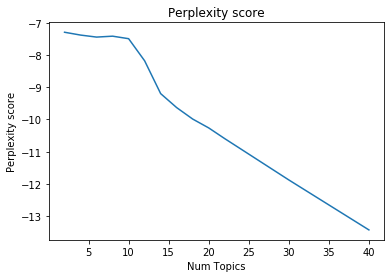

In [13]:
x = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 30, 40]

perplexity_val = [-7.2947367853462275, -7.382596099714195, -7.445003220336235, 
                  -7.41673423813644, -7.4946719168660865, -8.180829858425536, 
                  -9.19832086343388, -9.632309482475755, -9.98721, -10.26196028581457, 
                  -10.59439356859031, -10.914195285800625, -11.875396681837517, 
                  -13.42541487845994]

plt.plot(x, perplexity_val)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.title('Perplexity score')
#plt.plot(4,-7.3876 , 'go') 
plt.show()

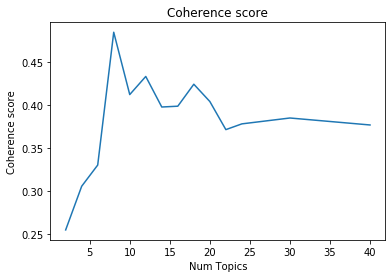

In [14]:
x = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 30, 40]
coherence_values = [0.25497084234025336, 0.30560027877646284, 0.3301596397937376, 
                    0.4841361658865407, 0.41188455975921257, 0.43287611912301366, 
                    0.3974545796475857, 0.3984029825556826, 0.4238694404185354, 
                    0.4038374867002704, 0.3712476759702932, 0.3779136273107931, 
                    0.38471770900453645, 0.3766330093397823]

plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title('Coherence score')
#plt.plot(4,0.4567 , 'go') 
plt.show()


## 1. 8 topics

In [15]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=False)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.020*"get" + 0.017*"day" + 0.016*"feel" + 0.015*"go" + 0.011*"time" + '
  '0.011*"work" + 0.009*"back" + 0.009*"pain" + 0.008*"week" + 0.007*"come"'),
 (1,
  '0.046*"surgery" + 0.031*"valve" + 0.012*"name" + 0.010*"hit" + '
  '0.010*"valve_replacement" + 0.008*"surgeon" + 0.008*"state" + '
  '0.007*"aortic" + 0.007*"replacement" + 0.006*"doubt"'),
 (2,
  '0.019*"lucky" + 0.012*"fatigue" + 0.011*"area" + 0.010*"panic" + '
  '0.010*"mentally" + 0.009*"grateful" + 0.008*"assessment" + 0.008*"tight" + '
  '0.007*"perfusion" + 0.007*"statin"'),
 (3,
  '0.015*"arrive" + 0.015*"statin" + 0.012*"diet" + 0.012*"mind" + '
  '0.011*"room" + 0.010*"follow" + 0.009*"run" + 0.009*"breathlessness" + '
  '0.008*"coffee" + 0.008*"antibiotic"'),
 (4,
  '0.027*"dog" + 0.020*"insurance" + 0.016*"scan" + 0.016*"term" + '
  '0.010*"life" + 0.010*"positive" + 0.009*"allergic" + 0.008*"daughter" + '
  '0.008*"live" + 0.007*"virus"'),
 (5,
  '0.020*"weight" + 0.013*"watch" + 0.011*"maybe" + 0.009*"eat

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # the lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, 
                                     dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda) # the higher the better.


Perplexity:  -7.41673423813644

Coherence Score:  0.4841361658865407


In [17]:
# Visualize the topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/dumitrescucristian/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.303197  0.018502       1        1  56.183964
0     -0.262442 -0.009265       2        1  29.187847
3      0.112499  0.236136       3        1   4.602774
5      0.101138 -0.122318       4        1   3.588783
4      0.096851 -0.059607       5        1   2.327045
1      0.072397 -0.029333       6        1   1.853416
2      0.090837 -0.015403       7        1   1.133433
7      0.091917 -0.018711       8        1   1.122733, topic_info=     Category        Freq     Term       Total  loglift  logprob
62    Default   57.000000  surgery   57.000000  30.0000  30.0000
23    Default  113.000000     life  113.000000  29.0000  29.0000
38    Default  137.000000    thank  137.000000  28.0000  28.0000
228   Default  219.000000      day  219.000000  27.0000  27.0000
16    Default  354.000000      get  354.000000  26.0000  26.0000
...       ...         ...      ...         ...      ...      ...
1498   Topic8    1.194233      oil    3.631066   3.3774  -5.6439
778    Topic8    1.060538  nursing    4.294630   3.0908  -5.7627
1075   Topic8    1.068156   report    8.171828   2.4546  -5.7555
804    Topic8    1.080843   chance   16.186131   1.7830  -5.7437
22     Topic8    1.027640     left    9.983512   2.2157  -5.7942

[424 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
766       2  0.962483  absolutely
2738      7  0.852176         act
1829      3  0.846302    activity
4020      8  0.678383       actor
1581      7  0.510811      actual
...     ...       ...         ...
43        1  0.945022       would
43        2  0.049478       would
1078      2  0.970574       write
171       1  0.799173        year
171       2  0.201593        year

[545 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 4, 6, 5, 2, 3, 8])

## 2. 15 topics

In [18]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=False)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.073*"wear" + 0.023*"tissue" + 0.023*"urge" + 0.014*"particular" + '
  '0.014*"animal" + 0.009*"traditional" + 0.006*"trauma" + 0.004*"ended" + '
  '0.004*"nightmare" + 0.004*"happening"'),
 (1,
  '0.029*"valve_replacement" + 0.021*"aortic" + 0.016*"mechanical" + '
  '0.015*"badly" + 0.015*"wonderful" + 0.012*"hole" + 0.011*"leak" + '
  '0.010*"days_ago" + 0.009*"replacement" + 0.008*"compare"'),
 (2,
  '0.025*"mentally" + 0.022*"available" + 0.021*"toe" + 0.018*"perfusion" + '
  '0.018*"corner" + 0.011*"investigate" + 0.010*"actual" + 0.010*"concerned" + '
  '0.004*"understandable" + 0.002*"nuclear"'),
 (3,
  '0.040*"antibiotic" + 0.026*"atrial" + 0.019*"remain" + 0.018*"sadly" + '
  '0.014*"fluid" + 0.012*"nose" + 0.012*"flutter" + 0.012*"much_better" + '
  '0.009*"anticipate" + 0.009*"stethoscope"'),
 (4,
  '0.013*"frightened" + 0.010*"implant" + 0.009*"piece" + 0.009*"jolt" + '
  '0.007*"decade" + 0.005*"prospect" + 0.002*"equipment" + 0.002*"conduction" '
  '+ 0.002*"adve

In [19]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, 
                                     dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.466303989457272

Coherence Score:  0.37457818231234813


In [20]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/dumitrescucristian/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.341285 -0.047086       1        1  46.362595
11     0.307332  0.027122       2        1  25.862133
6      0.198897 -0.188344       3        1  10.636403
8      0.176168  0.270172       4        1   7.921193
12     0.137091 -0.037946       5        1   6.040111
5     -0.125722 -0.003946       6        1   0.533345
7     -0.124942 -0.003959       7        1   0.480180
3     -0.121183 -0.000287       8        1   0.462013
1     -0.115024 -0.006837       9        1   0.364998
14    -0.113947  0.006394      10        1   0.323325
0     -0.115452 -0.003857      11        1   0.269214
13    -0.113370 -0.003535      12        1   0.240237
10    -0.115068 -0.003975      13        1   0.203289
2     -0.111371 -0.000806      14        1   0.194918
4     -0.104693 -0.003108      15        1   0.106040, topic_info=     Category        Freq      Term       Total  loglift  logprob
30    Default  172.000000      pain  172.000000  30.0000  30.0000
62    Default   90.000000   surgery   90.000000  29.0000  29.0000
16    Default  426.000000       get  426.000000  28.0000  28.0000
11    Default   86.000000     chest   86.000000  27.0000  27.0000
165   Default  276.000000      take  276.000000  26.0000  26.0000
...       ...         ...       ...         ...      ...      ...
2116  Topic15    0.007340    wisdom    0.541381   2.5483  -8.3761
2196  Topic15    0.007340   release    0.542610   2.5461  -8.3761
3623  Topic15    0.007340  recorder    0.541756   2.5476  -8.3762
407   Topic15    0.007357  electric    2.951562   0.8546  -8.3739
2701  Topic15    0.007340    random    0.541503   2.5481  -8.3762

[680 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
300       3  0.917884   ablation
1079      2  0.059793     accept
1079      3  0.896888     accept
272       3  0.947109     access
1396      2  0.113726       ache
...     ...       ...        ...
171       5  0.047921       year
802       1  0.066728  yesterday
802       2  0.311399  yesterday
802       4  0.289156  yesterday
802       5  0.333642  yesterday

[689 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 12, 7, 9, 13, 6, 8, 4, 2, 15, 1, 14, 11, 3, 5])